2024.3.21
x.min()=-32, x.max()=31, Integer.that_can_represent(x).bit_width=6


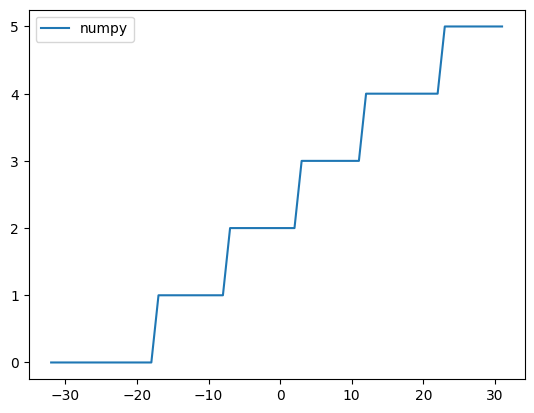

In [2]:
%matplotlib inline
from concrete.fhe import Compiler, round_bit_pattern
import numpy as np
import matplotlib.pyplot as plt
from concrete.ml.common.preprocessors import (
    CycleDetector,
    GraphProcessor,
    InsertRounding,
    TLUDeltaBasedOptimizer,
)
from concrete.fhe import Exactness, Configuration
from typing import List
from importlib.metadata import version
from concrete.fhe import Integer

print(version("concrete-python"))

x_min, x_max = -23 , 52
x_min, x_max = -32, 32
bias=2.3
# scale=0.01
# scale=0.05
# scale=0.15
scale = 0.1
n_bits_out=4
rounding_function = round_bit_pattern

def relu(x):
    # return (x>0) * x
    return np.where(x>0,x,0.)
    # return np.clip(x, 0, None)  # Fails because None Constant is not supported by CP

def f_float(x):
    x = x*scale + bias
    x = relu(x)
    return x

def f(x):
    x.astype(np.float64)
    x = f_float(x)
    x = np.clip(x, -2**(n_bits_out-1), 2**(n_bits_out-1)-1)
    x = np.round(x)
    x = x.astype(np.int64) # close tlu
    return x

x = np.arange(x_min, x_max)
print(f"{x.min()=}, {x.max()=}, {Integer.that_can_represent(x).bit_width=}")
compile_input = x[...,np.newaxis]
y = f(x)
fig, ax = plt.subplots()
ax.plot(x, y, label="numpy")
plt.legend()
plt.show()
plt.close(fig)

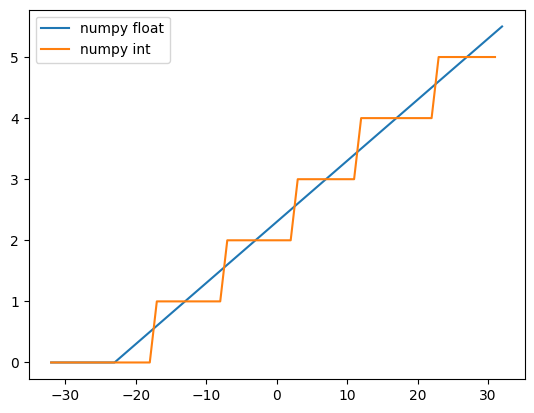

In [5]:
x_float = np.linspace(x_min, x_max, 1_000)
y_float = f_float(x_float)
fig, ax = plt.subplots()
ax.plot(x_float, y_float, label="numpy float")
ax.plot(x, y, label="numpy int")
plt.legend()
plt.show()
plt.close(fig)

In [ ]:
compiler = Compiler(f,{"x": "encrypted"})
circuit = compiler.compile(compile_input)

In [ ]:
y_sim = np.array([circuit.simulate(elt) for elt in compile_input])[:, 0]
fig, ax = plt.subplots()
ax.plot(x, y, label="numpy",)
ax.plot(x, y_sim, label="simulate", linestyle="--",)
plt.legend()
plt.show()
plt.close(fig)

In [ ]:
insert_rounding = InsertRounding(threshold=4, exactness=Exactness.EXACT)
cycle_detector = CycleDetector()
additional_pre_processors: List[GraphProcessor] = [insert_rounding]
additional_post_processors: List[GraphProcessor] = [cycle_detector]
compilation_configuration = Configuration(
    additional_pre_processors=additional_pre_processors,
    additional_post_processors=additional_post_processors,
    
)

compiler_round = Compiler(f,{"x": "encrypted"})
circuit_round = compiler_round.compile(compile_input, configuration=compilation_configuration)

In [ ]:
y_sim_round = np.array([circuit_round.simulate(elt) for elt in compile_input])[:, 0]
fig, ax = plt.subplots()
ax.plot(x, y, label="numpy",)
ax.plot(x, y_sim_round, label="simulate round", linestyle="--",)
plt.legend()
plt.show()
plt.close(fig)

In [ ]:
tlu_optimizer = TLUDeltaBasedOptimizer(verbose=True, exactness=Exactness.EXACT)
cycle_detector = CycleDetector()
additional_pre_processors: List[GraphProcessor] = [tlu_optimizer]
additional_post_processors: List[GraphProcessor] = [cycle_detector]
compilation_configuration = Configuration(
    additional_pre_processors=additional_pre_processors,
    additional_post_processors=additional_post_processors,
    
)

compiler_optim = Compiler(f,{"x": "encrypted"})
circuit_optim = compiler_optim.compile(compile_input, configuration=compilation_configuration)

In [ ]:
y_sim_optim = np.array([circuit_optim.simulate(elt) for elt in compile_input])[:, 0]
fig, ax = plt.subplots()
ax.plot(x, y, label="numpy",)
ax.plot(x, y_sim_optim, label="simulate optim", linestyle="--",)
plt.legend()
plt.show()
plt.close(fig)

In [ ]:
stats = tlu_optimizer._statistics[0]
print(stats)

In [ ]:
stats["b"] = 25

In [ ]:
tx = x.copy()
tx = (tx * stats["a"]) - stats["b"]
print(f"{Integer.that_can_represent(tx).bit_width=}")
tx = rounding_function(tx, stats["lsbs_to_remove"])
tx = (tx + stats["b"]) / (stats["a"])
ty = f(tx)
print(f"{Integer.that_can_represent(x).bit_width=}")
x_round = rounding_function(x, Integer.that_can_represent(x).bit_width - stats["msbs_to_keep"])

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, y, label="numpy",)
ax.plot(x, ty, label="numpy optim", linestyle="--",)
plt.legend()
plt.show()
plt.close(fig)

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, y, label="numpy",)
ax.plot(x, ty, label="numpy optim", linestyle="--",)
ax.vlines(np.unique(tx), y.min(), y.max(), label="optimized rounding levels", linestyle="--", color="grey", alpha=.5)
plt.legend()
plt.show()
plt.close(fig)

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, y, label="numpy",)
ax.vlines(np.unique(x_round), y.min(), y.max(), label="rounding levels", linestyle="--", color="grey", alpha=.5)
plt.legend()
plt.show()
plt.close(fig)

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, y, label="numpy",)
ax.vlines(np.unique(tx), y.min(), y.max(), label="optimized rounding levels", linestyle="--", color="grey", alpha=.5)
plt.legend()
plt.show()
plt.close(fig)

In [ ]:
np.diff(np.arange(len(y)-1)[np.diff(y).astype(bool)])

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("x")
ax.set_ylabel("x transformed")
ax.plot(x, tx, label="optimized", linestyle="--",)
ax.plot(x, x_round, label="just rounded",)
plt.legend()
plt.show()
plt.close(fig)